In [38]:
import numpy as np
import pandas as pd

from typing import List, Tuple, Dict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
import logging
import sys
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = PROJECT_ROOT / "data" / "processed"

LOAD DATA

In [39]:
EVENTS_PROPS_FILE = DATA_DIR / "events_with_properties.csv"
ITEM_PROPS_FILE = DATA_DIR / "item_properties.csv" 
USER_FEATS_FILE = DATA_DIR / "users_pipeline.csv"

In [40]:
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df
events = load(EVENTS_PROPS_FILE)
item_props = load(ITEM_PROPS_FILE)
user_feats = load(USER_FEATS_FILE)

In [41]:
df = user_feats.rename(
    columns={
        'predicted_avg_transaction':'pred_money_each_purchase',
        'predicted_purchases_bgf':'pred_no_purchase',
        'survival_30':'survival_prob'
    }
).copy()


In [42]:
df.head()

,Unnamed: 0,visitorid,total_events,first_event,last_event,recency_days,tenure_days,total_views,total_addtocarts,total_tx,...,active_days,events_per_active_day,business_label,pred_money_each_purchase,predicted_clv_bg_gamma,pred_no_purchase,origin,time_to_event,churned,survival_prob
0,3926,3926,13,2015-06-02 19:44:15.832,2015-08-18 20:41:30.407,30,78,8,3,3,...,3,4.333333,At Risk,122745.966383,1310.135500,1.067355e-02,2015-06-02 20:01:56.963,14.193558,1,0.215266
1,4537,4537,10,2015-05-14 01:23:42.959,2015-09-07 01:26:13.013,11,117,5,3,2,...,3,3.333333,At Risk,134100.331110,1536.451779,1.145748e-02,2015-09-06 18:08:08.780,11.369201,0,0.716486
2,5042,5042,13,2015-07-12 16:23:12.305,2015-07-12 17:46:39.453,67,1,7,3,3,...,1,13.000000,Potential Loyalists,104825.387057,0.009852,9.398102e-08,2015-07-12 16:48:47.267,0.021983,1,0.320050
3,6699,6699,104,2015-05-07 21:30:27.547,2015-05-08 03:01:06.009,132,1,92,8,4,...,2,52.000000,Loyal Customers,96356.189166,0.000481,4.991540e-09,2015-05-07 21:54:11.023,0.211585,1,0.045010
4,8043,8043,10,2015-07-21 23:46:29.406,2015-08-20 21:48:51.263,28,30,6,2,2,...,3,3.333333,At Risk,117981.475519,2708.549366,2.295741e-02,2015-08-17 20:17:10.774,31.279595,0,0.836325


In [43]:
df['business_label'].value_counts()

business_label
At Risk                730
Potential Loyalists    221
Loyal Customers         80
Name: count, dtype: int64

In [44]:
df["baseline_clv"] = (
    df["pred_no_purchase"] *
    df["pred_money_each_purchase"] *
    df["survival_prob"]
)

print(df["baseline_clv"].describe())


count    1.031000e+03
mean     7.455676e+04
std      9.515731e+05
min      6.500420e-97
25%      7.683428e-03
50%      4.777327e+00
75%      1.088780e+03
max      2.743795e+07
Name: baseline_clv, dtype: float64


In [ ]:
# DEFINE FROM DATA
segment_stats = df.groupby("business_label").agg(
    churn_risk = ("survival_prob", lambda x: 1 - x.mean()),
    purchase_freq = ("pred_no_purchase", "mean"),
    clv = ("baseline_clv", "mean")
)

segment_stats
max_churn = segment_stats["churn_risk"].max()

segment_stats["k"] = (
    segment_stats["churn_risk"] / max_churn
) * 1.3
max_freq = segment_stats["purchase_freq"].max()

segment_stats["c"] = (
    1 - segment_stats["purchase_freq"] / max_freq
) * 0.6
segment_stats["m"] = (
    segment_stats["churn_risk"] * 0.12
)
SEGMENT_PARAMS = {}

for seg, row in segment_stats.iterrows():
    SEGMENT_PARAMS[seg] = {
        "k": row["k"],
        "c": row["c"],
        "m": row["m"]
    }

SEGMENT_PARAMS


{'At Risk': {'k': np.float64(1.3),
  'c': np.float64(0.5960799026972933),
  'm': np.float64(0.07820241224389889)},
 'Loyal Customers': {'k': np.float64(0.6131388114528963),
  'c': np.float64(0.0),
  'm': np.float64(0.03688379545844122)},
 'Potential Loyalists': {'k': np.float64(1.1532779416581898),
  'c': np.float64(0.5821057378090623),
  'm': np.float64(0.06937624386565303)}}

In [83]:
# A function to produce discount-dependent lift ranges
def get_lift_ranges(segment, X):
    p = SEGMENT_PARAMS[segment]

    k = p["k"]
    c = p["c"]
    m = p["m"]

    # purchase lift
    purchase_min = k * (X ** 0.85)
    purchase_max = k * (X ** 1.05)
    
    #churn
    response_center = 1 / (1 + np.exp(-c * (X - m)))

    churn_min = response_center * 0.8
    churn_max = response_center * 1.2

    return (purchase_min, purchase_max), (churn_min, churn_max)


In [84]:
# Modify your policy simulation to accept ranges + discount X
def simulate_discount_policy(df, segment_name, X, n_simulations=1000, seed=42):
    purchase_range, churn_range = get_lift_ranges(segment_name, X)
    purchase_min, purchase_max = purchase_range
    churn_min, churn_max = churn_range
    results = []
    np.random.seed(seed)
    mask = df["business_label"] == segment_name
    for _ in range(n_simulations):
        temp = df.copy()
        purchase_lift = np.random.uniform(purchase_min, purchase_max)
        churn_reduction = np.random.uniform(churn_min, churn_max)
        temp.loc[mask, "new_no_purchase"] = (
            temp.loc[mask, "pred_no_purchase"] * (1 + purchase_lift)
        )
        temp.loc[~mask, "new_no_purchase"] = temp.loc[~mask, "pred_no_purchase"]
        churn_prob = 1 - temp.loc[mask, "survival_prob"]
        new_churn_prob = churn_prob * (1 - churn_reduction)
        temp.loc[mask, "new_survival_prob"] = 1 - new_churn_prob
        temp.loc[~mask, "new_survival_prob"] = temp.loc[~mask, "survival_prob"]
        temp["new_clv"] = (
            temp["new_no_purchase"] *
            temp["pred_money_each_purchase"] *
            temp["new_survival_prob"]
        )
        temp["discount_cost"] = (
            X *
            temp["new_no_purchase"] *
            temp["pred_money_each_purchase"] *
            mask
        )
        temp["net_gain"] = (
            temp["new_clv"]
            - temp["baseline_clv"]
            - temp["discount_cost"]
        )
        results.append(temp["net_gain"].sum())
    return np.array(results)


In [85]:
#Build optimization algorithm over discount space
DISCOUNT_DOMAIN = np.linspace(0.01, 0.20, 20)


In [86]:
def run_discount_optimization(df, segment_name):

    results = []

    for X in DISCOUNT_DOMAIN:

        gains = simulate_discount_policy(df, segment_name, X)

        results.append({
            "discount": X,
            "mean_gain": gains.mean(),
            "median_gain": np.median(gains),    
            "prob_positive": np.mean(gains > 0),
            "worst_5pct": np.percentile(gains, 5),
            "best_95pct": np.percentile(gains, 95)
        })

    return pd.DataFrame(results)


In [87]:
#Run optimisation per segment
segments = ['At Risk', 'Potential Loyalists', 'Loyal Customers']

segment_outputs = {}

for seg in segments:
    print("Executing segment:", seg)
    segment_outputs[seg] = run_discount_optimization(df, seg)


Executing segment: At Risk
Executing segment: Potential Loyalists
Executing segment: Loyal Customers


In [88]:
#Identify optimal discount for each segment
optimal_results = {}

for seg, table in segment_outputs.items():
    best = table.loc[table["mean_gain"].idxmax()]
    optimal_results[seg] = best

pd.DataFrame(optimal_results).T


,discount,mean_gain,median_gain,prob_positive,worst_5pct,best_95pct
At Risk,0.12,579855.182694,581741.300023,1.0,281684.711518,872260.019073
Potential Loyalists,0.08,303061.861695,302348.459639,1.0,169038.238367,436892.887916
Loyal Customers,0.01,589956.658630,589410.422313,1.0,336712.761782,847906.097558


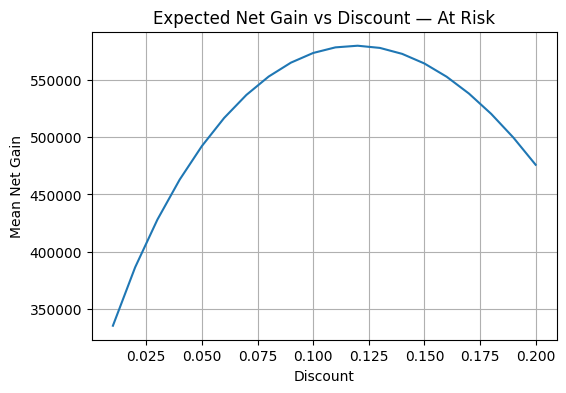

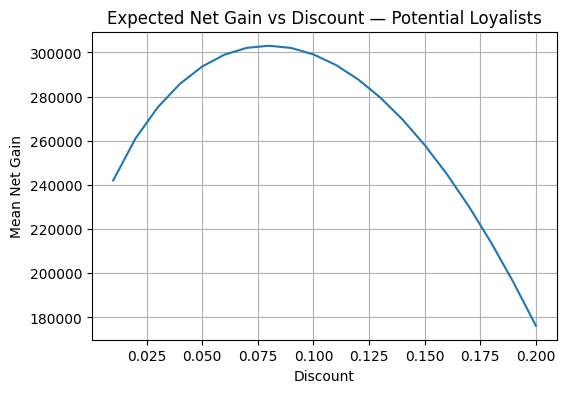

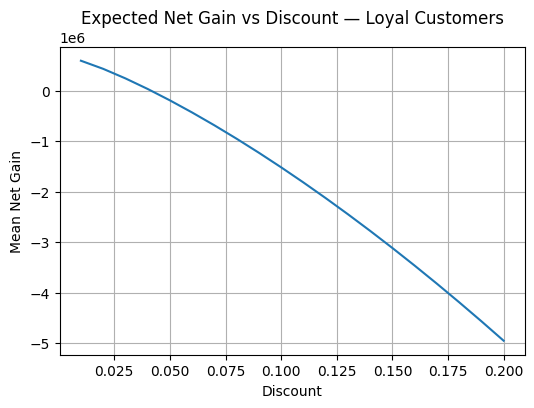

In [89]:
#visual curve plotting
for seg, table in segment_outputs.items():
    plt.figure(figsize=(6,4))
    plt.plot(table["discount"], table["mean_gain"])
    plt.title(f"Expected Net Gain vs Discount — {seg}")
    plt.xlabel("Discount")
    plt.ylabel("Mean Net Gain")
    plt.grid()
    plt.show()


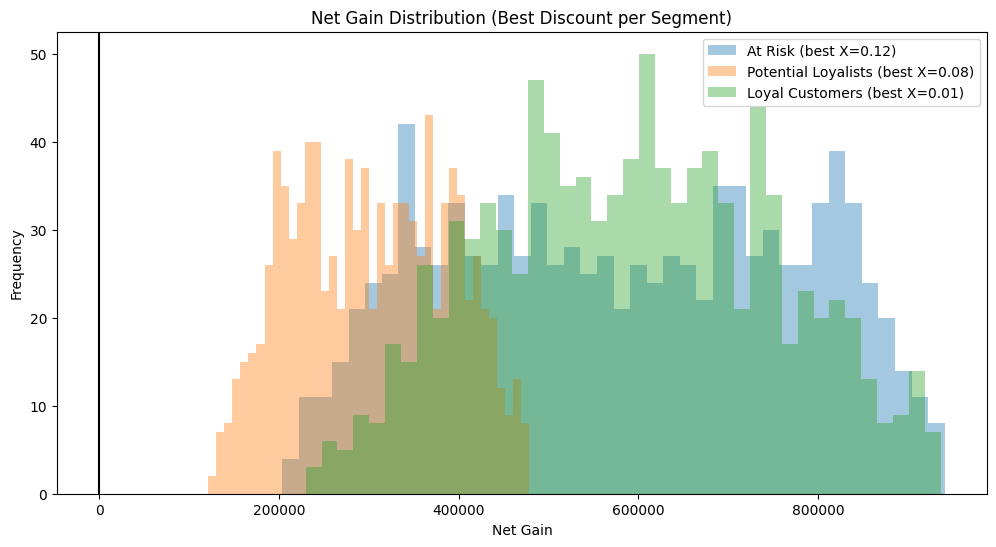

In [90]:
plt.figure(figsize=(12, 6))

for seg, results in segment_outputs.items():

    best_row = results.loc[results["mean_gain"].idxmax()]
    best_discount = best_row["discount"]
    
    gains = simulate_discount_policy(df, seg, best_discount)

    plt.hist(gains, bins=40, alpha=0.4, label=f"{seg} (best X={best_discount:.2f})")

plt.axvline(0, color='black')
plt.title("Net Gain Distribution (Best Discount per Segment)")
plt.xlabel("Net Gain")
plt.ylabel("Frequency")
plt.legend()
plt.show()


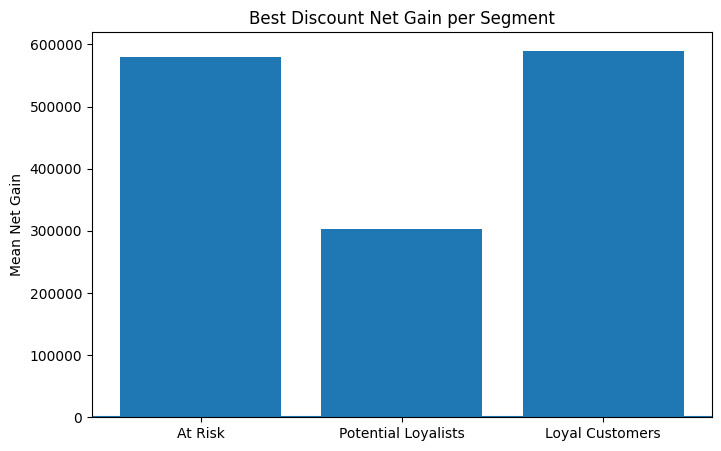

,segment,best_discount,mean_gain
0,At Risk,0.12,579855.182694
1,Potential Loyalists,0.08,303061.861695
2,Loyal Customers,0.01,589956.658630


In [91]:
mean_values = []

for seg, results in segment_outputs.items():
    row = results.loc[results["mean_gain"].idxmax()]
    mean_values.append((seg, row["discount"], row["mean_gain"]))

mean_df = pd.DataFrame(mean_values, columns=["segment", "best_discount", "mean_gain"])

plt.figure(figsize=(8,5))
plt.bar(mean_df["segment"], mean_df["mean_gain"])
plt.axhline(0)
plt.title("Best Discount Net Gain per Segment")
plt.ylabel("Mean Net Gain")
plt.show()

mean_df


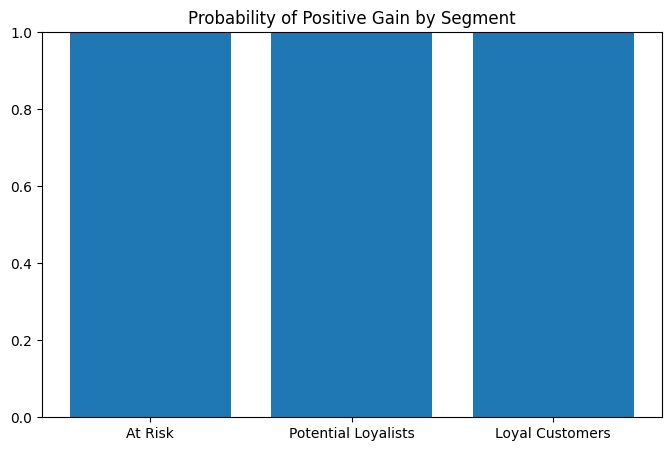

,segment,best_discount,prob_positive_gain
0,At Risk,0.01,1.0
1,Potential Loyalists,0.01,1.0
2,Loyal Customers,0.01,1.0


In [92]:
prob_values = []

for seg, results in segment_outputs.items():
    row = results.loc[results["prob_positive"].idxmax()]
    prob_values.append((seg, row["discount"], row["prob_positive"]))

prob_df = pd.DataFrame(prob_values, columns=["segment", "best_discount", "prob_positive_gain"])

plt.figure(figsize=(8,5))
plt.bar(prob_df["segment"], prob_df["prob_positive_gain"])
plt.title("Probability of Positive Gain by Segment")
plt.ylim(0,1)
plt.show()

prob_df


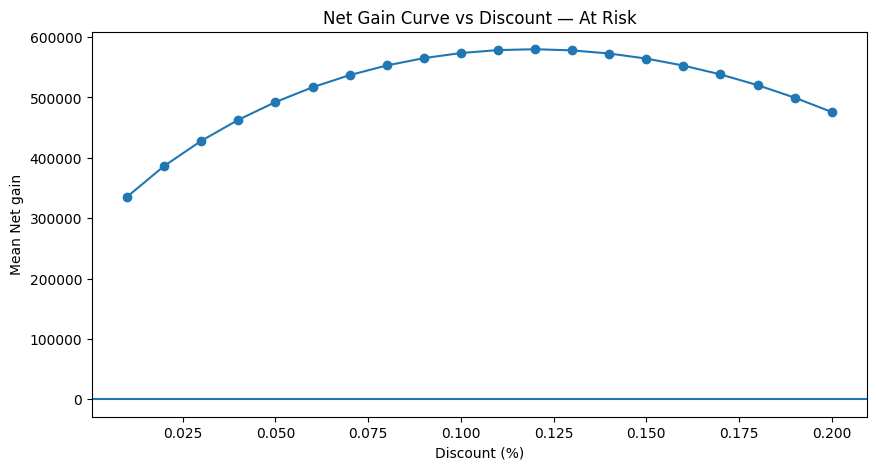

In [93]:
SEG = "At Risk"
seg_df = segment_outputs[SEG]

plt.figure(figsize=(10,5))
plt.plot(seg_df["discount"], seg_df["mean_gain"], marker='o')
plt.axhline(0)
plt.title(f"Net Gain Curve vs Discount — {SEG}")
plt.xlabel("Discount (%)")
plt.ylabel("Mean Net gain")
plt.show()


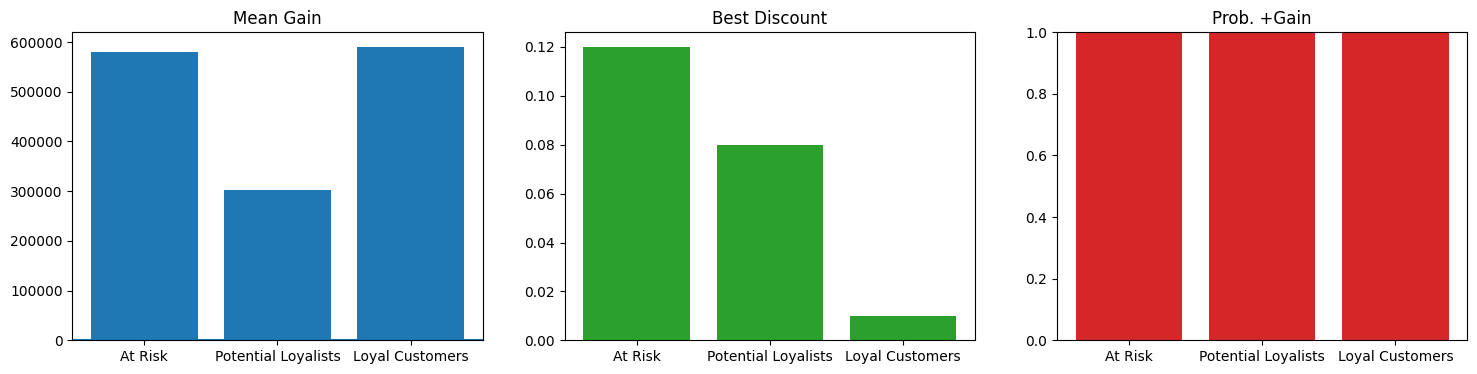

In [94]:
fig, axes = plt.subplots(1,3, figsize=(18,4))

# – mean gain
axes[0].bar(mean_df["segment"], mean_df["mean_gain"], color="tab:blue")
axes[0].set_title("Mean Gain")
axes[0].axhline(0)

# – best discount labels
axes[1].bar(mean_df["segment"], mean_df["best_discount"], color="tab:green")
axes[1].set_title("Best Discount")

# – prob positivity
axes[2].bar(prob_df["segment"], prob_df["prob_positive_gain"], color="tab:red")
axes[2].set_ylim(0,1)
axes[2].set_title("Prob. +Gain")

plt.show()


In [95]:
recommendations = []

for seg, results in segment_outputs.items():
    row = results.sort_values(
        ["prob_positive", "mean_gain"],
        ascending=[False, False]
    ).iloc[0]

    recommendations.append({
        "segment": seg,
        "best_discount": row["discount"],
        "mean_gain": row["mean_gain"],
        "prob_positive": row["prob_positive"],
        "worst_5pct": row["worst_5pct"],
        "best_95pct": row["best_95pct"]
    })

recommend_df = pd.DataFrame(recommendations)
recommend_df


,segment,best_discount,mean_gain,prob_positive,worst_5pct,best_95pct
0,At Risk,0.12,579855.182694,1.0,281684.711518,872260.019073
1,Potential Loyalists,0.08,303061.861695,1.0,169038.238367,436892.887916
2,Loyal Customers,0.01,589956.658630,1.0,336712.761782,847906.097558


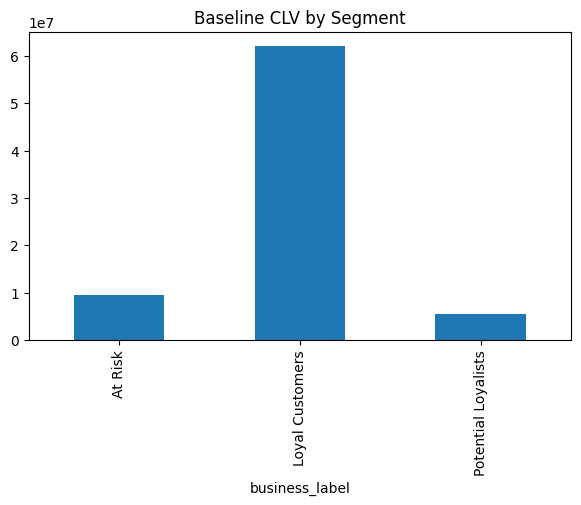

In [96]:
segment_clv = df.groupby("business_label")["baseline_clv"].sum()

plt.figure(figsize=(7,4))
segment_clv.plot(kind="bar")
plt.title("Baseline CLV by Segment")
plt.show()


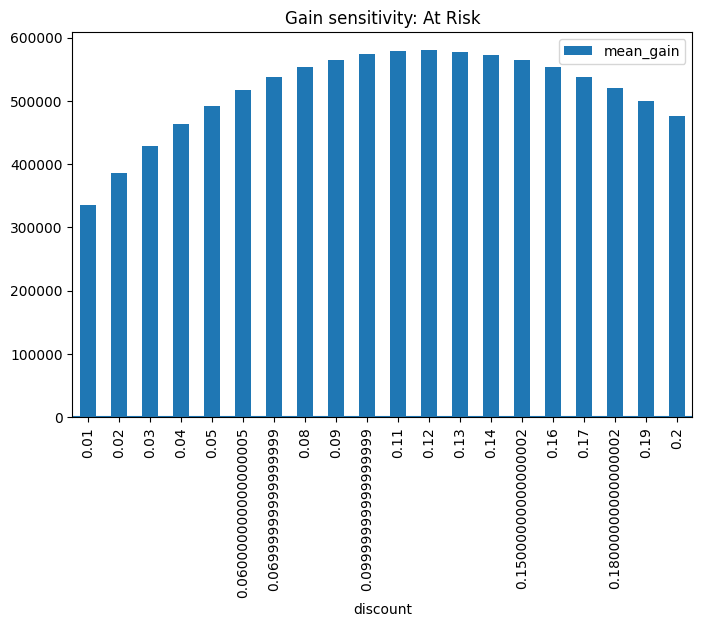

In [97]:
pivot = seg_df.pivot_table(
    index="discount",
    values="mean_gain"
)

pivot.plot(kind="bar", figsize=(8,5))
plt.axhline(0)
plt.title(f"Gain sensitivity: {SEG}")
plt.show()
